In [21]:
import torch
import random

random.seed(0)
torch.manual_seed(0)

In [22]:
import numpy as np

import sys
import os
sys.path.append(os.path.join(os.environ['BART_TOOLBOX_PATH'], 'python'))
from bart import bart

num_readout_points = 320
oversampling_ratio = 2

points_per_phase = num_readout_points * oversampling_ratio

gatraj = bart(1, f"traj -r -x{num_readout_points} -y800 -G -o{oversampling_ratio}")

print(gatraj.shape)

import torch
from einops import rearrange

gatraj = torch.tensor(gatraj)
gatraj = rearrange(gatraj, 'pos readout phase -> phase readout pos')
gatraj = gatraj[:,:,:2]

print(gatraj.shape)



(3, 640, 800)
torch.Size([800, 640, 2])


In [24]:
# Dataset
trainlistpath = "/home/liyy/data1/moco/datasets/.Fastmri_pics/trainlist.txt"
vallistpath = "/home/liyy/data1/moco/datasets/.Fastmri_pics/vallist.txt"
testlistpath = "/home/liyy/data1/moco/datasets/.Fastmri_pics/testlist.txt"

with open(trainlistpath, 'r') as f:
    trainlist = f.readlines()
    trainlist = [(line.split()[0], int(line.split()[1])) for line in trainlist]

with open(vallistpath, 'r') as f:
    vallist = f.readlines()
    vallist = [(line.split()[0], int(line.split()[1])) for line in vallist]

with open(testlistpath, 'r') as f:
    testlist = f.readlines()
    testlist = [(line.split()[0], int(line.split()[1])) for line in testlist]

import torch
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

from models import mynn as mynn
from models.mynn import functional as myf

from random import shuffle

from einops import rearrange, repeat

from torchkbnufft import KbNufft, KbNufftAdjoint, calc_tensor_spmatrix, calc_density_compensation_function, ToepNufft


# ismrmrd_header rss csm kspace
class MyDataset(Dataset):
    def __init__(self, filelist, num_subset = None, transform=None, lazy_memory=True, output_keys=["kspace", "after_transform"], output_type = dict):
        super(MyDataset, self).__init__()
        self.filelist = filelist
        self.num_subset = num_subset
        self.transform = transform
        self.lazy_cache = lazy_memory
        self.output_keys = output_keys
        self.output_type = output_type

        if self.num_subset is not None:
            self.filelist = self.filelist[:self.num_subset]

        self._cache = {}
        self._keys = ["kspace", "csm", "rss"]

        if not lazy_memory:
            try:
                for file in filelist:
                    path, index = file
                    if path not in self._cache:
                        self.load(path)
            except MemoryError as e: # The total size of the dataset is about 400GB
                print("Memory Error in preloading the dataset.", e)
                print("Lazy memory is recommended. Automatically switch to lazy memory.")
                self.release(ratio=0.75)
                self.lazy_cache = True

    def load(self, path):
        with np.load(path) as data:
            self._cache[path] = {key: torch.tensor(data[key]) for key in self._keys}
            self._cache[path].update(self.transform(self._cache[path]))

    def release(self, ratio = 0.5):
        assert 0 < ratio <= 1 , "The ratio must be a float between 0 and 1."

        keys_to_delete = shuffle(list(self._cache.keys()))[:int(len(self._cache) * ratio)]
        for key in keys_to_delete:
            del self._cache[key]


    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self, idx):
        file = self.filelist[idx]
        path, index = file

        if path not in self._cache:
            try:
                self.load(path)
            except MemoryError as e:
                self.release()
                self.load(path) # try again

        if self.output_type == dict:
            return {key: self._cache[path][key][index] for key in self.output_keys}
        elif self.output_type == list:
            return [self._cache[path][key][index] for key in self.output_keys]
        


class Transform(nn.Module):
    def __init__(self, image_size, num_spokes_full, num_spokes_partial):
        super(Transform, self).__init__()
        self.image_size = image_size
        self.num_spokes_full = num_spokes_full
        self.num_spokes_partial = num_spokes_partial


        self._nufft_obj = KbNufft(im_size=image_size, device='cuda')
        self._inufft_obj = KbNufftAdjoint(im_size=image_size, device='cuda')

        toep_ob = ToepNufft()


        self.traj_raw = gatraj.clone().to(torch.float32) # phase readout pos
        self.traj_raw = torch.view_as_complex(self.traj_raw) # phase readout
        # use complex number to represent the trajectory position
        # for example, traj[0,0] = 0.1 + 0.2j means the first point position in cartesian coordinate is (0.1, 0.2)
        # in other words, traj[0,0] = 0.1 + 0.2j means the first point position in polar coordinate is ( abs(0.1 + 0.2j), angle(0.1 + 0.2j) )

        self.traj_full = self.traj_raw[:num_spokes_full]
        self.traj_partial = self.traj_raw[:num_spokes_partial]


    def nufft(self, image, traj):
        device = image.device
        image = image.to(torch.device("cuda"))
        traj = traj.to(torch.device("cuda"))

        traj_shape = traj.shape
        traj = traj / 160 * torch.pi # bart normalization to torchkbnufft normalization
        traj = torch.view_as_real(traj)
        traj = rearrange(traj, 'phase readout pos -> pos (readout phase)')

        res = self._nufft_obj(image, traj)
        res = rearrange(res, '... (readout phase) ->... phase readout', phase=traj_shape[0], readout=traj_shape[1])

        res = res.to(device)
        return res
    
    def inufft(self, kspace, traj):
        device = kspace.device
        kspace = kspace.to(torch.device("cuda"))
        traj = traj.to(torch.device("cuda"))

        traj_shape = traj.shape
        traj = traj / 160 * torch.pi # bart normalization to torchkbnufft normalization
        traj = torch.view_as_real(traj)
        traj = rearrange(traj, 'phase readout pos -> pos (readout phase)')
        kspace = rearrange(kspace, '... phase readout ->... (readout phase)')

        interp_mats = calc_tensor_spmatrix(traj,im_size=self.image_size, table_oversamp=2)
        dcomp = calc_density_compensation_function(ktraj=traj, im_size=self.image_size)

        res = self._inufft_obj(kspace * dcomp, traj, interp_mats)
        res = res.to(device)
        return res

    def mean_std_norm_complex(self, data):
        real = data.real
        imag = data.imag
        real = (real - real.mean()) / real.std()
        imag = (imag - imag.mean()) / imag.std()
        return real + 1j * imag


    def forward(self, sample):
        kspace = sample["kspace"].to(torch.complex64)
        image = myf.ktoi(kspace)
        kspace_full = self.nufft(image, self.traj_full)
        kspace_partial = self.nufft(image, self.traj_partial)
        pos_seq_full = repeat(self.traj_full, 'phase readout -> slice phase readout', slice=image.shape[0])
        pos_seq_partial = repeat(self.traj_partial, 'phase readout -> slice phase readout', slice=image.shape[0])
        return {"kspace":kspace, "kspace_before": kspace_full, "kspace_after": kspace_partial, "pos_seq_before": pos_seq_full, "pos_seq_after": pos_seq_partial, "image": image}
    

transform = Transform((320, 320), 800, 20)

train_dataset = MyDataset(trainlist, transform=transform, output_keys=["kspace_before", "kspace_after", "pos_seq_before", "pos_seq_after", "image"], output_type=dict)
val_dataset = MyDataset(trainlist, transform=transform, output_keys=["kspace_before", "kspace_after", "pos_seq_before", "pos_seq_after", "image"], output_type=dict, num_subset=64)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=4)

print(len(train_dataset))
print(len(val_dataset))
    

1
1


image:  1  16  320  320  kspace_before:  1  16  800  640  kspace_after:  1  16  20  640  pos_seq_before:  800  640  pos_seq_after:  20  640
image_recon_before:  1  16  320  320  image_recon_after:  1  16  320  320
mse 0.0022826672066003084 0.20908494293689728
ssim 0.9912022 0.8243649


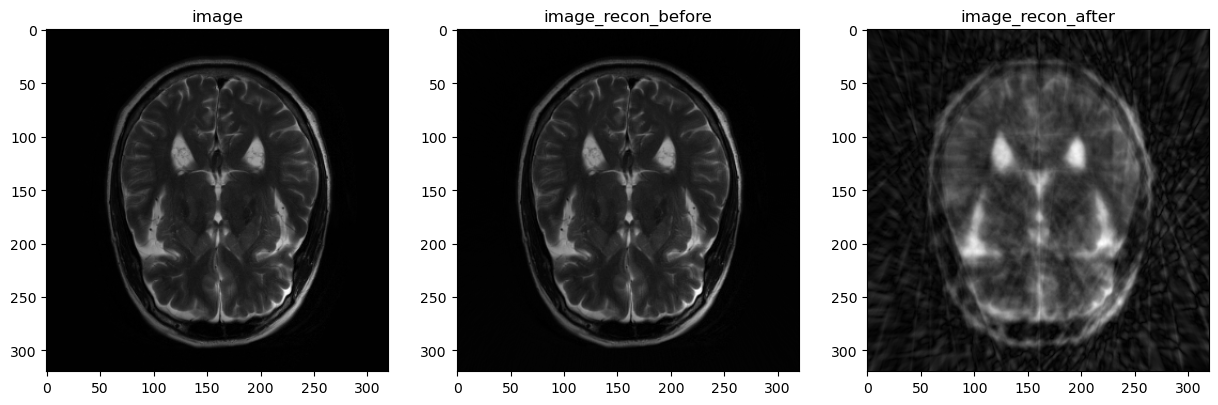

In [25]:
# show train dataset sample 0 - 5

import matplotlib.pyplot as plt
from torch.nn import functional as F
from skimage.metrics import structural_similarity
from models.mynn import functional as myf

import random

random.seed(0)

def mean_std_norm_complex(data):
    data_real = data.real
    data_imag = data.imag
    data_real = (data_real - data_real.mean()) / data_real.std()
    data_imag = (data_imag - data_imag.mean()) / data_imag.std()
    return data_real + 1j * data_imag

def mse(image1, image2):
    image1 = mean_std_norm_complex(image1)
    image1 = torch.view_as_real(image1)
    image2 = mean_std_norm_complex(image2)
    image2 = torch.view_as_real(image2)
    return F.mse_loss(image1, image2)

def ssim(image1, image2):
    image1 = mean_std_norm_complex(image1)
    image1 = myf.complex_to_real(image1).numpy()
    image2 = mean_std_norm_complex(image2)
    image2 = myf.complex_to_real(image2).numpy()
    return structural_similarity(image1[0], image2[0], channel_axis=0, data_range=image1.max() - image1.min())

for i in random.sample(range(0, len(train_dataset)), min(5, len(train_dataset))):
    sample = train_dataset[i]
    image = sample["image"].unsqueeze(0)
    kspace_full = sample["kspace_before"].unsqueeze(0)
    kspace_partial = sample["kspace_after"].unsqueeze(0)
    pos_seq_full = sample["pos_seq_before"]
    pos_seq_partial = sample["pos_seq_after"]

    # print(pos_seq_full)

    # print shapes
    print('image:', *image.shape, 'kspace_before:', *kspace_full.shape, 'kspace_after:', *kspace_partial.shape, 'pos_seq_before:', *pos_seq_full.shape, 'pos_seq_after:', *pos_seq_partial.shape, sep='  ')

    image_recon_full = transform.inufft(kspace_full, pos_seq_full)
    image_recon_partial = transform.inufft(kspace_partial, pos_seq_partial)

    print('image_recon_before:', *image_recon_full.shape, 'image_recon_after:', *image_recon_partial.shape, sep='  ')

    print('mse', mse(image, image_recon_full).item(), mse(image, image_recon_partial).item())

    print('ssim', ssim(image, image_recon_full), ssim(image, image_recon_partial))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(torch.abs(image[0][0]), cmap="gray")
    plt.title("image")
    plt.subplot(1, 3, 2)
    plt.imshow(torch.abs(image_recon_full[0][0]), cmap="gray")
    plt.title("image_recon_before")
    plt.subplot(1, 3, 3)
    plt.imshow(torch.abs(image_recon_partial[0][0]), cmap="gray")
    plt.title("image_recon_after")
    plt.show()
    
    

image:  1  16  320  320  kspace_before:  1  16  800  640  kspace_after:  1  16  20  640  pos_seq_before:  800  640  pos_seq_after:  20  640
Done.
Done.
Done.
Done.
image_recon_before:  320  320  image_recon_after:  320  320


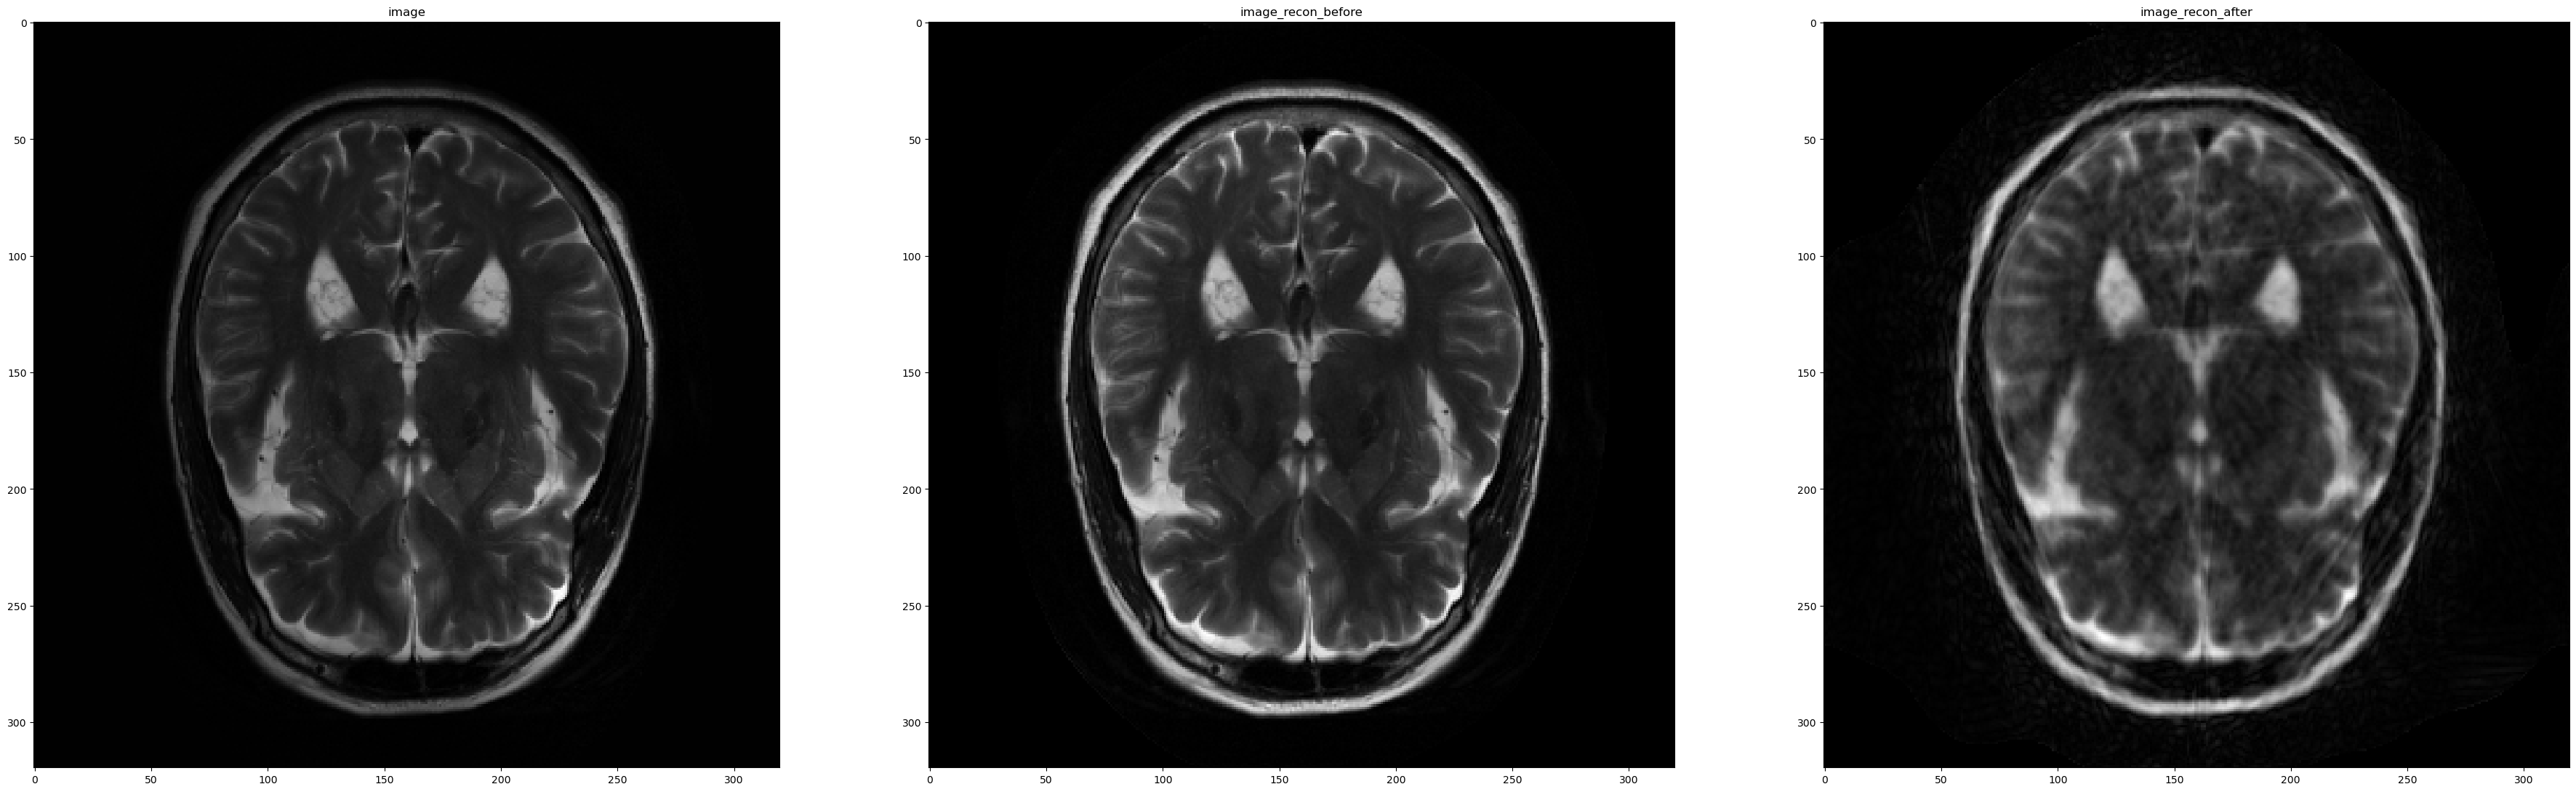

In [26]:
# bart recon

import matplotlib.pyplot as plt
from torch.nn import functional as F
from skimage.metrics import structural_similarity
from models.mynn import functional as myf

import random

from einops import rearrange, repeat

import sys
import os
sys.path.append(os.path.join(os.environ['BART_TOOLBOX_PATH'], 'python'))
from bart import bart

random.seed(0)

def mean_std_norm_complex(data):
    data_real = data.real
    data_imag = data.imag
    data_real = (data_real - data_real.mean()) / data_real.std()
    data_imag = (data_imag - data_imag.mean()) / data_imag.std()
    return data_real + 1j * data_imag

def mse(image1, image2):
    image1 = mean_std_norm_complex(image1)
    image1 = torch.view_as_real(image1)
    image2 = mean_std_norm_complex(image2)
    image2 = torch.view_as_real(image2)
    return F.mse_loss(image1, image2)

def ssim(image1, image2):
    image1 = mean_std_norm_complex(image1)
    image1 = myf.complex_to_real(image1).numpy()
    image2 = mean_std_norm_complex(image2)
    image2 = myf.complex_to_real(image2).numpy()
    return structural_similarity(image1[0], image2[0], channel_axis=0, data_range=image1.max() - image1.min())


def cal_csm(kdata, ktraj, im_size):
    image = bart(1, f"nufft -x {im_size[0]}:{im_size[1]}:1 -i -g", ktraj, kdata)
    kspace= bart(1, f"fft -u 7", image)
    csm = bart(1, "ecalib -m 1", kspace)
    return csm

def pics_nuifft(kdata, ktraj, im_size):
    image = bart(1, f"nufft -x {im_size[0]}:{im_size[1]}:1 -i -g", ktraj, kdata)
    kspace= bart(1, f"fft -u 7", image)
    csm = bart(1, "ecalib -m 1", kspace)
    recon = bart(1, f'pics -S -g -d0 -R W:3:0:{0.001} -i {50}', kspace, csm)
    return recon

def pics_noncart(kdata, ktraj, im_size):
    csm = cal_csm(kdata, ktraj, im_size)
    recon = bart(1, f'pics -g -d0 -S -r{1e-4} -i {50} -t', ktraj, kdata, csm)
    return recon

def k_reshape(kdata):
    return rearrange(kdata, 'batch coil phase readout -> 1 readout phase coil 1 1 1 1 1 1 1 1 1 1 1 batch').numpy()

def pos_reshape(pos_seq):
    pos_seq = torch.view_as_real(pos_seq).to(torch.complex64)
    pos_seq = rearrange(pos_seq, " phase readout pos -> pos readout phase").numpy()
    pos_seq = np.concatenate([pos_seq, np.zeros([1, *pos_seq.shape[1:]])], axis=0)
    return pos_seq


for i in random.sample(range(0, len(train_dataset)), min(1, len(train_dataset))):
    sample = train_dataset[i]
    image = sample["image"].unsqueeze(0)
    kspace_before = sample["kspace_before"].unsqueeze(0)
    kspace_after = sample["kspace_after"].unsqueeze(0)
    pos_seq_before = sample["pos_seq_before"]
    pos_seq_after = sample["pos_seq_after"]

    # print(pos_seq_full)

    # print shapes
    print('image:', *image.shape, 'kspace_before:', *kspace_before.shape, 'kspace_after:', *kspace_after.shape, 'pos_seq_before:', *pos_seq_before.shape, 'pos_seq_after:', *pos_seq_after.shape, sep='  ')

    import sys
    import os
    sys.path.append(os.path.join(os.environ['BART_TOOLBOX_PATH'], 'python'))
    from bart import bart
    
    # print("csm:", csm.shape)
    # csm = rearrange(csm, "coil readout phase -> readout phase 1 coil 1 1 1 1 1 1 1 1 1 1 1 1").numpy()

    kspace_before = k_reshape(kspace_before)
    pos_seq_before = pos_reshape(pos_seq_before)


    image_recon_before = pics_noncart(kspace_before, pos_seq_before, (320,320))
    # image_recon_before = pics_nuifft(kspace_before, pos_seq_before, (320,320))
    image_recon_before = torch.tensor(image_recon_before)

    kspace_after = k_reshape(kspace_after)
    pos_seq_after = pos_reshape(pos_seq_after)

    
    image_recon_after = pics_noncart(kspace_after, pos_seq_after, (320,320))
    # image_recon_after = pics_nuifft(kspace_after, pos_seq_after, (320,320))
    image_recon_after = torch.tensor(image_recon_after)

    print('image_recon_before:', *image_recon_before.shape, 'image_recon_after:', *image_recon_after.shape, sep='  ')

    # print('mse', mse(image, image_recon_before).item(), mse(image, image_recon_after).item())

    # print('ssim', ssim(image, image_recon_before), ssim(image, image_recon_after))

    plt.figure(figsize=(45, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(torch.abs(image[0][0]), cmap="gray")
    plt.title("image")
    plt.subplot(1, 3, 2)
    plt.imshow(torch.abs(image_recon_before[:,:]), cmap="gray")
    plt.title("image_recon_before")
    plt.subplot(1, 3, 3)
    plt.imshow(torch.abs(image_recon_after[:,:]), cmap="gray")
    plt.title("image_recon_after")
    plt.show()

    
    

In [27]:
from torch import nn
import torch
import math
from typing import List
from einops import rearrange, repeat, pack, unpack

class SinusoidalPositionEncoding1d(nn.Module):
    """Sinusoidal Position Encoding for 1-dimensions"""
    def __init__(self, d_model, pos_scale=1e2):
        super(SinusoidalPositionEncoding1d, self).__init__()
        self.d_model = d_model
        self.pos_scale = pos_scale
        self.conv1d = nn.Conv1d(1, d_model, 1)

        self.register_buffer('_div_term', torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)))

    def forward(self, tensor = None, position = None):
        """tensor:[batch_size, seq_len, d_model]  
        position:[batch_size, seq_len, 1]  
        tensor is None: return positional encoding  
        position is None: return [0-1]*scale positional encoding for tensor  
        """
        assert tensor is not None or position is not None, "Either tensor or position must be provided"

        if position is None:
            position = torch.arange(tensor.size(1), device=tensor.device).unsqueeze(0).unsqueeze(-1).float()
        position = (position - position.min()) / (position.max() - position.min())
        position = position * self.pos_scale

        assert len(position.size()) == 3, "position must be [batch_size, seq_len, 1]"

        pe = torch.zeros(position.size(0), position.size(1), self.d_model, device=position.device)
        pe[:, :, 0::2] = torch.sin(position * self._div_term)
        pe[:, :, 1::2] = torch.cos(position * self._div_term)

        if tensor is None:
            return pe        
        return tensor + pe




class SinusoidalPositionEncodingmd(nn.Module):
    """Multi-dimensional Sinusoidal Position Encoding"""
    def __init__(self, d_model, pos_scale: float | List[float] = 1e2, n_dims=2):
        super(SinusoidalPositionEncodingmd, self).__init__()
        self.n_dims = n_dims
        self.d_model = d_model
        self.register_buffer('pos_scale', torch.tensor(pos_scale if isinstance(pos_scale, list) else [pos_scale] * n_dims))

        assert d_model % n_dims == 0, "d_model must be divisible by n_dims"
        self.register_buffer('_div_term', torch.exp(torch.arange(0, self.d_model // self.n_dims, 2).float() * -(math.log(10000.0) / self.d_model // self.n_dims)))

    
    def forward(self, tensor, position = None):
        """tensor:[batch_size, seq_len, d_model]  
        position:[batch_size, seq_len, n_dims]  
        tensor is None: return positional encoding   
        position is None: return [0-1]*scale positional encoding for tensor   
        """
        assert tensor is not None or position is not None, "Either tensor or position must be provided"

        if position is None:
            position = []
            for i in range(self.n_dims):
                pos = torch.arange(tensor.size(1), device=tensor.device).unsqueeze(0).unsqueeze(-1).float()
                position.append(pos)
            position = torch.cat(position, dim=-1)
        position = (position - position.min()) / (position.max() - position.min())
        position = position * self.pos_scale

        assert len(position.size()) == 3, "position must be [batch_size, seq_len, n_dims]"

        pe = torch.zeros(position.size(0), position.size(1), self.d_model, device=position.device)
        for i in range(self.n_dims): # [aaabbbccc]
            pe[:, :, i * self.d_model // self.n_dims:(i+1) * self.d_model // self.n_dims:2] = torch.sin(position[:, :, i:i+1] * self._div_term)
            pe[:, :, i * self.d_model // self.n_dims + 1:(i+1) * self.d_model // self.n_dims:2] = torch.cos(position[:, :, i:i+1] * self._div_term)

        if tensor is None:
            return pe
        return tensor + pe


class LearnablePositionEncoding(nn.Module):
    """Learnable Position Encoding"""
    def __init__(self, d_model, max_len=512):
        super(LearnablePositionEncoding, self).__init__()
        self.d_model = d_model
        self.max_len = max_len
        self._pe = nn.Parameter(torch.randn(max_len, d_model))

    def forward(self, tensor):
        return tensor + self._pe[:tensor.size(0), :]



import torch
from torch import nn

from einops import rearrange, repeat, pack, unpack
from einops.layers.torch import Rearrange

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x
    
class ViT(nn.Module):
    def __init__(self, *, seq_len, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        assert (seq_len % patch_size) == 0

        num_patches = seq_len // patch_size
        patch_dim = channels * patch_size

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (n p) -> b n (p c)', p = patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, series):
        x = self.to_patch_embedding(series)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, 'd -> b d', b = b)

        x, ps = pack([cls_tokens, x], 'b * d')

        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        cls_tokens, _ = unpack(x, ps, 'b * d')

        return self.mlp_head(cls_tokens)

In [28]:


class MAE_Kradial(nn.Module):
    def __init__(self, 
                 mask_ratio = 0.5,
                 pts_readout = 640,
                 in_channels = 16, out_channels = 16,
                 d_model_encoder = 1024, d_model_decoder = 1024,
                 nlayers_encoder = 4, nlayers_decoder = 4,
                 nheads_encoder = 8, nheads_decoder = 8,
                 ):
        super().__init__()
        self.d_model_encoder = d_model_encoder
        self.d_model_decoder = d_model_decoder
        self.nlayer_encoder = nlayers_encoder
        self.nlayer_decoder = nlayers_decoder
        self.nheads_encoder = nheads_encoder
        self.nheads_decoder = nheads_decoder
        self.mask_ratio = mask_ratio
        self.pts_readout = pts_readout
        self.in_channels = in_channels
        self.out_channels = out_channels


        ### Encoder
        self.input_embed = nn.Sequential(
            mynn.IFFTn(dim = -1),
            mynn.Complex2Real(),
            Rearrange('batch channel phase readout -> batch phase (readout channel)'),
            nn.LayerNorm(pts_readout * in_channels * 2), 
            nn.Linear(pts_readout * in_channels * 2, d_model_encoder, bias=True),
            nn.LayerNorm(d_model_encoder)
        )

        self.norm_encoder = nn.LayerNorm(d_model_encoder)

        self.pe_encoder = SinusoidalPositionEncoding1d(d_model = d_model_encoder, pos_scale=100)

        self.encoder = Transformer(dim = d_model_encoder, depth = nlayers_encoder, heads = nheads_encoder, mlp_dim = 2048, dim_head = d_model_encoder // nheads_encoder)


        ### Decoder
        self.decoder_embed = nn.Linear(d_model_encoder, d_model_decoder, bias=True)

        self.pe_decoder = SinusoidalPositionEncoding1d(d_model = d_model_decoder, pos_scale=100)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, d_model_decoder))

        self.decoder = Transformer(dim = d_model_decoder, depth = nlayers_decoder, heads = nheads_decoder, mlp_dim = 2048, dim_head = d_model_decoder // nheads_decoder)

        self.norm_decoder = nn.LayerNorm(d_model_decoder)

        self.output_embed = nn.Sequential(
            nn.Linear(d_model_decoder, pts_readout * out_channels * 2, bias=True),
            Rearrange('batch phase (readout channel) -> batch channel phase readout', channel = out_channels * 2, readout = pts_readout),
            mynn.Real2Complex(),
            mynn.FFTn(dim = -1),
        )



    def random_masking(self, x, mask_ratio):
        """
        https://github.com/facebookresearch/mae/tree/main

        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    
    def forward_encoder_train(self, x, pos, mask_ratio):
        # x: [batch, phase, readout * channel * 2]
        # pos: [batch, phase, 1]

        ### Encoder
        # in training mode, the shape of kdata is matched with the shape of ktraj
        # kdata should be masked as same as ktraj
        x = self.pe_encoder(x, pos)
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # cls token
        pass

        # encode
        
        x = self.encoder(x)
        x = self.norm_encoder(x)

        return x, mask, ids_restore
    
    def forward_decoder_train(self, x, pos, ids_restore):
        # x: [batch, phase, readout * channel * 2]
        # pos: [batch, phase, 1]

        ### Decoder
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] - x.shape[1], 1)
        x = torch.cat([x, mask_tokens], dim=1)
        x = torch.gather(x, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle

        # pe
        x = self.pe_decoder(x, pos)

        # apply Transformer blocks
        x = self.decoder(x)
        x = self.norm_decoder(x)

        # predictor projection
        x = self.output_embed(x)

        # remove cls token
        pass

        return x
    
    def forward_encoder_val(self, x, pos):
        # x: [batch, phase, readout * channel * 2]
        # pos: [batch, phase, 1]

        x = self.pe_encoder(x, pos)

        # cls token
        pass

        x = self.encoder(x)
        x = self.norm_encoder(x)
        return x
    
    def forward_decoder_val(self, x, pos):
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], pos.shape[1] - x.shape[1], 1)
        x = torch.cat([x, mask_tokens], dim=1)

        # pe
        x = self.pe_decoder(x, pos)

        # apply Transformer blocks
        x = self.decoder(x)
        x = self.norm_decoder(x)

        # predictor projection
        x = self.output_embed(x)

        # remove cls token
        pass

        return x


    def forward(self, kdata, ktraj):
        # kdata: [batch, channel, phase, readout]
        # ktraj: [batch, phase, readout]
        kdata = self.input_embed(kdata) # [batch, phase, readout * channel]
        ktraj_angle = torch.angle(ktraj).mean(dim = -1).unsqueeze(-1) # [batch, angle]


        if self.training:
            ktraj_angle = ktraj_angle[:,:kdata.shape[1]]
            # encode
            encoder_memory, mask, ids_restore = self.forward_encoder_train(kdata, ktraj_angle, self.mask_ratio)
            
            # decode
            kdata_pred = self.forward_decoder_train(encoder_memory, ktraj_angle, ids_restore)

            return kdata_pred

        else:
            # in evaluation mode, the shape of kdata is matched with the shape of ktraj[:, :num_phase_kdata]
            encoder_memory= self.forward_encoder_val(kdata, ktraj_angle[:,:kdata.shape[1]])

            pred = self.forward_decoder_val(encoder_memory, ktraj_angle)
            return pred



In [29]:
# Train

from models import mynn
from models.mynn import functional as myf
import torch
import torch.nn
from torch.nn import functional as F

def recon_loss(y_pred, y_true):
    image_pred = myf.complex_to_real(y_pred)
    image_true = myf.complex_to_real(y_true)

    mse_score = F.mse_loss(image_pred, image_true)

    return mse_score


def predict(model: nn.Module, data):
    x = data['kspace_after'].to('cuda')
    pos_before = data['pos_seq_before'].to('cuda')
    pos_after = data['pos_seq_after'].to('cuda')
    y = data['image'].to('cuda')

    if model.training:
        image_true = torch.zeros_like(y)
        for batch in range(image_true.shape[0]):
            image_true[batch] = transform.inufft(x[batch], pos_after[batch])
        image_true = transform.mean_std_norm_complex(image_true)
        x_pos = pos_after
    else:
        image_true = y
        x_pos = pos_before

    kdata_pred = model(x, pos_before)

    image_pred = torch.zeros_like(y)
    for batch in range(image_pred.shape[0]):
        image_pred[batch] = transform.inufft(kdata_pred[batch], x_pos[batch])
    image_pred = transform.mean_std_norm_complex(image_pred)

    recon_score = recon_loss(image_pred, image_true)

    return image_pred, recon_score


def trainstep(model: nn.Module, data, optimizer):
    model.train()
    optimizer.zero_grad()

    image_pred, score = predict(model, data)

    score.backward()
    optimizer.step()

    return score.item()


def valstep(model: nn.Module, data):
    model.eval()
    with torch.no_grad():
        image_pred, score = predict(model, data)

    return score.item()



# Train

from torch.utils.data import DataLoader
import os

model = MAE_Kradial(mask_ratio=0.75,
                    pts_readout=640,
                    in_channels=16,
                    out_channels=16,
                    d_model_encoder=1024,
                    d_model_decoder=512,
).to('cuda')

import torchinfo

print(torchinfo.summary(model))

trainloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas = [0.9, 0.98], eps = 1e-9)


from torch.nn import functional as F

loss_his_train = []

loss_his_val = []

for epoch in range(300):
    epoch_loss = 0
    for i, data in enumerate(trainloader):
        loss_value_train = trainstep(model, data, optimizer)
        epoch_loss += loss_value_train

    loss_his_train.append(epoch_loss / len(trainloader))

    # print every 100 epochs
    if epoch % 10 == 0:
        # print loss
        print(f"train: epoch: {epoch}, avgloss: {epoch_loss / len(trainloader)}")

        # validation
        epoch_loss_val = 0
        for i, data in enumerate(valloader):
            loss_value_val = valstep(model, data)
            epoch_loss_val += loss_value_val
        loss_his_val.append(epoch_loss_val / len(valloader))
        
        print(f"val: epoch: {epoch}, avgloss: {epoch_loss_val / len(valloader)}")

        # savepoint
        torch.save(model.state_dict(), f"model_{epoch}.pth")
        # delete old-1000th savepoint
        if epoch > 100:
            os.remove(f"model_{epoch-100}.pth")




Layer (type:depth-idx)                             Param #
MAE_Kradial                                        512
├─Sequential: 1-1                                  --
│    └─IFFTn: 2-1                                  --
│    └─Complex2Real: 2-2                           --
│    └─Rearrange: 2-3                              --
│    └─LayerNorm: 2-4                              40,960
│    └─Linear: 2-5                                 20,972,544
│    └─LayerNorm: 2-6                              2,048
├─LayerNorm: 1-2                                   2,048
├─SinusoidalPositionEncoding1d: 1-3                --
│    └─Conv1d: 2-7                                 2,048
├─Transformer: 1-4                                 --
│    └─ModuleList: 2-8                             --
│    │    └─ModuleList: 3-1                        8,396,800
│    │    └─ModuleList: 3-2                        8,396,800
│    │    └─ModuleList: 3-3                        8,396,800
│    │    └─ModuleList: 3-4       

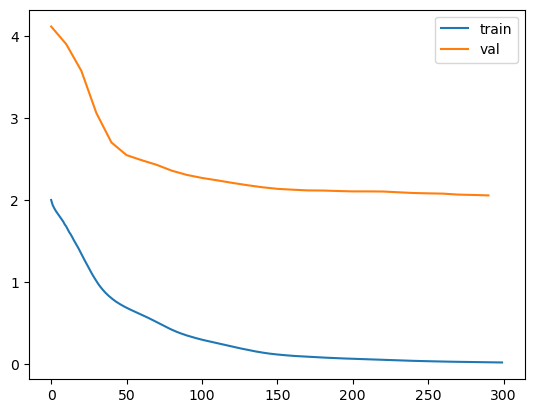

In [35]:
# plot loss curve

from matplotlib import pyplot as plt


plt.figure()
plt.plot(loss_his_train, label='train')
plt.plot(np.arange(len(loss_his_val))*10,loss_his_val, label='val')
plt.legend()
plt.show()

tensor(1.0021)


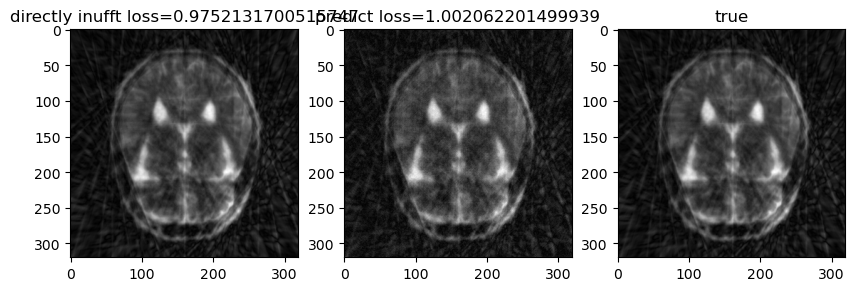

In [31]:
from models.mynn.functional import ktoi, real_to_complex
from matplotlib import pyplot as plt
from torch.nn import functional as F

def image_norm(image):
    return (image - image.min()) / (image.max() - image.min())



# show image of model(train[i])

eps = 1e-8

with torch.no_grad():
    for data in train_loader:
        image_pred, score = predict(model, data)

        image_pred_showable = image_pred.abs()
        image_true_showable = image.abs()

        image_pred_showable = image_norm(image_pred_showable)
        image_true_showable = image_norm(image_true_showable)

        x = data['kspace_after']
        pos = data['pos_seq_after']

        image_corp = transform.inufft(x, pos[0])
        image_corp = transform.mean_std_norm_complex(image_corp)
        image_true_showable = image_norm(image_corp.abs())

        # show abs err
        err = recon_loss(image_pred.cpu(), image.cpu())
        print(err)

        image_pred_showable, image_true_showable, = image_pred_showable.cpu(), image_true_showable.cpu()

        plt.figure(figsize=(10,20))
        plt.subplot(1,3,1)
        plt.imshow(image_corp[0][0].abs(), cmap='gray')
        plt.title(f'directly inufft loss={recon_loss(image_corp.cpu(), image.cpu())}')
        plt.subplot(1,3,2)
        plt.imshow(image_pred_showable[0][0].abs(), cmap='gray')
        plt.title(f'predict loss={recon_loss(image_pred.cpu(), image.cpu())}')
        plt.subplot(1,3,3)
        plt.imshow(image_true_showable[0][0].abs(), cmap='gray')
        plt.title(f'true')
        plt.show()

        break

